# 2 Moons example

This is a test of the BitNet in a generative, Normalizing Flow setup. It is based on a tutorial designed by T.Quadfasel, M.Sommerhalder and S.Diefenbacher, https://github.com/uhh-pd-ml/flow-exercise that was later adopted by S.Diefenbacher for the lecture at https://indico.scc.kit.edu/event/2852/. 
The adapted tutorials can be found at https://colab.research.google.com/drive/1v2P9Epb46RssGiDQtoJ_QWlO4T4OE0fO and 
https://colab.research.google.com/drive/159Uova_QyCMPi8ar-y-V2ouzWSpztUK1.

The version here was adapted to BitNet by Claudius Krause. 


## Imports and class definitions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# we will get the dataset from scikit-learn
import sklearn.datasets as datasets

# our usual PyTorch functionality
import torch
from torch import nn, Tensor
from torch import optim

# the nflows functions what we will need in order to build our flow
from nflows.flows.base import Flow # a container that will wrap the parts that make up a normalizing flow
from nflows.distributions.normal import StandardNormal # Gaussian latent space distribution
from nflows.transforms.base import CompositeTransform # a wrapper to stack simpler transformations to form a more complex one
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform # the basic transformation, which we will stack several times
from nflows.transforms.autoregressive import MaskedPiecewiseRationalQuadraticAutoregressiveTransform # the basic transformation, which we will stack several times
from nflows.transforms.permutations import ReversePermutation # a layer that simply reverts the order of outputs


cuda = torch.cuda.is_available()
if cuda:
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(f"Running on {device}")

Running on cuda:0


In [2]:
# taken from https://github.com/bayesiains/nflows/blob/master/nflows/transforms/autoregressive.py
# and https://github.com/bayesiains/nflows/blob/master/nflows/transforms/made.py
# to be able to make a BitNet Version of it

# BitLinear layers taken from MNIST example notebook

from torch.nn import functional as F
from nflows.transforms.autoregressive import AutoregressiveTransform
from nflows.transforms.splines import rational_quadratic
from nflows.transforms.splines.rational_quadratic import (
    rational_quadratic_spline,
    unconstrained_rational_quadratic_spline,
)
from nflows.transforms import made as made_module
from nflows.utils import torchutils

class MaskedLinear(nn.Linear):
    """A linear module with a masked weight matrix."""

    def __init__(
        self,
        in_degrees,
        out_features,
        autoregressive_features,
        random_mask,
        is_output,
        bias=True,
    ):
        super().__init__(
            in_features=len(in_degrees), out_features=out_features, bias=bias
        )
        mask, degrees = self._get_mask_and_degrees(
            in_degrees=in_degrees,
            out_features=out_features,
            autoregressive_features=autoregressive_features,
            random_mask=random_mask,
            is_output=is_output,
        )
        self.register_buffer("mask", mask)
        self.register_buffer("degrees", degrees)

    @classmethod
    def _get_mask_and_degrees(
        cls, in_degrees, out_features, autoregressive_features, random_mask, is_output
    ):
        if is_output:
            out_degrees = torchutils.tile(
                _get_input_degrees(autoregressive_features),
                out_features // autoregressive_features,
            )
            mask = (out_degrees[..., None] > in_degrees).float()

        else:
            if random_mask:
                min_in_degree = torch.min(in_degrees).item()
                min_in_degree = min(min_in_degree, autoregressive_features - 1)
                out_degrees = torch.randint(
                    low=min_in_degree,
                    high=autoregressive_features,
                    size=[out_features],
                    dtype=torch.long,
                )
            else:
                max_ = max(1, autoregressive_features - 1)
                min_ = min(1, autoregressive_features - 1)
                out_degrees = torch.arange(out_features) % max_ + min_
            mask = (out_degrees[..., None] >= in_degrees).float()

        return mask, out_degrees

    def forward(self, x, context=None):
        return F.linear(x, self.weight * self.mask, self.bias)


class BitLinear(nn.Linear):
    """
    BitLinear is a custom linear layer that performs binarization of weights and quantization of activations

    Args:
        in_features (int): Number of input features.
        out_features (int): Number of output features.
        bias (bool, optional): If set to False, the layer will not learn an additive bias. Default is True.
    """

    def __init__(
        self,
        in_features: int,
        out_features: int,
        bias: bool = True,
        b: int = 8,
    ):
        super().__init__(in_features, out_features, bias)
        self.in_features = in_features
        self.out_features = out_features
        self.eps = 1e-8
        #self.norm = nn.LayerNorm(in_features)

        # Quantiziation and dequantization
        self.Q_b = 2 ** (b - 1)  # use this to define quantized bit
        self.beta = torch.zeros((self.weight.shape[0], 1))
        self.gamma = torch.zeros((self.weight.shape[0], 1))

    def ste(self, x):
        """
        Applies the sign function for binarization and uses Straight-Through Estimator (STE) during backward pass.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tensor: Binarized tensor.
        """
        binarized_x = torch.sign(x)
        binarized_x = (binarized_x - x).detach() + x
        return binarized_x

    def binarize_weights(self):
        """
        Binarizes the weights of the layer using STE.

        Returns:
            Tensor: Binarized weights tensor.
        """
        alpha = self.weight.mean()
        self.beta = self.weight.abs().mean()
        binarized_weights = self.ste(self.weight - alpha)

        return binarized_weights

    def quantize_activations(self, x):
        """
        Quantizes the activations of the layer.

        Args:
            x (Tensor): Input tensor.
            b (int, optional): Number of bits for quantization. Default is 8.

        Returns:
            Tensor: Quantized activations tensor.
        """
        self.gamma = x.abs().max()
        quantized_x = torch.clamp(
            x * self.Q_b / (self.gamma + self.eps),
            -self.Q_b + self.eps,
            self.Q_b - 1.0 - self.eps,
        )
        return quantized_x

    def dequantize_activations(self, x):
        """
        Dequantizes the activations of the layer.

        Args:
            x (Tensor): Quantized input tensor.

        Returns:
            Tensor: Dequantized activations tensor.
        """
        return x * self.gamma * self.beta / self.Q_b

    def forward(self, x: Tensor) -> Tensor:
        """
        Forward pass of the BitLinear layer.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tensor: Output tensor.
        """
        # Normalize input
        #x = self.norm(x)

        # Binarize weights and quantize activations
        binarized_weights = self.binarize_weights()

        # Quantize input
        x_quant = self.quantize_activations(x)

        # Perform linear transformation
        output = torch.nn.functional.linear(x_quant, binarized_weights, self.bias)

        # Dequantize activations
        output = self.dequantize_activations(output)

        # Return output
        return output

class BitLinear158b(BitLinear):
    """
    BitLinear158b layer allowing for tertiar weights (-1,0,1). Rest is keeped
    as in BitLinear

    Args:
        in_features (int): Number of input features.
        out_features (int): Number of output features.
        bias (bool, optional): If set to False, the layer will not learn an additive bias. Default is True.
        num_groups (int, optional): Number of groups to divide the weights and activations into. Default is 1.
    """

    def __init__(
        self,
        in_features: int,
        out_features: int,
        bias: bool = True,
        b: int = 8,
    ):
        super().__init__(in_features, out_features, bias, b)

    def _absmean_quantization(self, weight, gamma):
        quantized_weight = torch.clamp(
            torch.round(weight / (gamma + self.eps)), min=-1, max=1
        )
        quantized_weight = (quantized_weight - weight).detach() + weight
        return quantized_weight

    def binarize_weights(self):
        """
        Quantizes the weights using the absmean quantization function.

        Returns:
            Tensor: Quantized weight tensor.
        """
        self.beta = self.weight.abs().mean()
        binarized_weight = self._absmean_quantization(self.weight, self.beta)

        return binarized_weight

class MaskedBitLinear(nn.Linear):
    """
    BitLinear is a custom linear layer that performs binarization of weights and quantization of activations

    Args:
        in_features (int): Number of input features.
        out_features (int): Number of output features.
        bias (bool, optional): If set to False, the layer will not learn an additive bias. Default is True.
    """

    def __init__(
        self,
        in_degrees,
        out_features: int,
        autoregressive_features,
        random_mask,
        is_output: bool,
        bias: bool = True,
        b: int = 8,
    ):
        super().__init__(
            in_features=len(in_degrees), out_features=out_features, bias=bias
        )
        mask, degrees = self._get_mask_and_degrees(
            in_degrees=in_degrees,
            out_features=out_features,
            autoregressive_features=autoregressive_features,
            random_mask=random_mask,
            is_output=is_output,
        )
        self.register_buffer("mask", mask)
        self.register_buffer("degrees", degrees)

        #super().__init__(in_features, out_features, bias)
        self.in_features = len(in_degrees)
        self.out_features = out_features
        self.eps = 1e-8
        #self.norm = nn.LayerNorm(self.in_features)

        # Quantiziation and dequantization
        self.Q_b = 2 ** (b - 1)  # use this to define quantized bit
        self.beta = torch.zeros((self.weight.shape[0], 1))
        self.gamma = torch.zeros((self.weight.shape[0], 1))

    @classmethod
    def _get_mask_and_degrees(
        cls, in_degrees, out_features, autoregressive_features, random_mask, is_output
    ):
        if is_output:
            out_degrees = torchutils.tile(
                _get_input_degrees(autoregressive_features),
                out_features // autoregressive_features,
            )
            mask = (out_degrees[..., None] > in_degrees).float()

        else:
            if random_mask:
                min_in_degree = torch.min(in_degrees).item()
                min_in_degree = min(min_in_degree, autoregressive_features - 1)
                out_degrees = torch.randint(
                    low=min_in_degree,
                    high=autoregressive_features,
                    size=[out_features],
                    dtype=torch.long,
                )
            else:
                max_ = max(1, autoregressive_features - 1)
                min_ = min(1, autoregressive_features - 1)
                out_degrees = torch.arange(out_features) % max_ + min_
            mask = (out_degrees[..., None] >= in_degrees).float()

        return mask, out_degrees        
        
    def ste(self, x):
        """
        Applies the sign function for binarization and uses Straight-Through Estimator (STE) during backward pass.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tensor: Binarized tensor.
        """
        binarized_x = torch.sign(x)
        binarized_x = (binarized_x - x).detach() + x
        return binarized_x

    def binarize_weights(self):
        """
        Binarizes the weights of the layer using STE.

        Returns:
            Tensor: Binarized weights tensor.
        """
        alpha = self.weight.mean()
        self.beta = self.weight.abs().mean()
        binarized_weights = self.ste(self.weight - alpha)

        return binarized_weights

    def quantize_activations(self, x):
        """
        Quantizes the activations of the layer.

        Args:
            x (Tensor): Input tensor.
            b (int, optional): Number of bits for quantization. Default is 8.

        Returns:
            Tensor: Quantized activations tensor.
        """
        self.gamma = x.abs().max()
        quantized_x = torch.clamp(
            x * self.Q_b / (self.gamma + self.eps),
            -self.Q_b + self.eps,
            self.Q_b - 1.0 - self.eps,
        )
        return quantized_x

    def dequantize_activations(self, x):
        """
        Dequantizes the activations of the layer.

        Args:
            x (Tensor): Quantized input tensor.

        Returns:
            Tensor: Dequantized activations tensor.
        """
        return x * self.gamma * self.beta / self.Q_b

    def forward(self, x: Tensor, context=None) -> Tensor:
        """
        Forward pass of the BitLinear layer.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tensor: Output tensor.
        """

        # Normalize input
        #x = self.norm(x)

        # Binarize weights and quantize activations
        binarized_weights = self.binarize_weights()

        # Quantize input
        x_quant = self.quantize_activations(x)

        # Perform linear transformation
        output = torch.nn.functional.linear(x_quant, binarized_weights*self.mask, self.bias)

        # Dequantize activations
        output = self.dequantize_activations(output)

        # Return output
        return output
    
class MaskedBitLinear158b(MaskedBitLinear):
    """
    BitLinear158b layer allowing for tertiar weights (-1,0,1). Rest is keeped
    as in BitLinear

    Args:
        in_features (int): Number of input features.
        out_features (int): Number of output features.
        bias (bool, optional): If set to False, the layer will not learn an additive bias. Default is True.
        num_groups (int, optional): Number of groups to divide the weights and activations into. Default is 1.
    """

    def __init__(
        self,
        in_degrees,
        out_features: int,
        autoregressive_features,
        random_mask,
        is_output: bool,
        bias: bool = True,
        b: int = 8,
    ):
        super().__init__(in_degrees, out_features, autoregressive_features, random_mask, is_output, bias, b)        

    def _absmean_quantization(self, weight, gamma):
        quantized_weight = torch.clamp(
            torch.round(weight / (gamma + self.eps)), min=-1, max=1
        )
        quantized_weight = (quantized_weight - weight).detach() + weight
        return quantized_weight

    def binarize_weights(self):
        """
        Quantizes the weights using the absmean quantization function.

        Returns:
            Tensor: Quantized weight tensor.
        """
        self.beta = self.weight.abs().mean()
        binarized_weight = self._absmean_quantization(self.weight, self.beta)

        return binarized_weight
    
def _get_input_degrees(in_features):
    """Returns the degrees an input to MADE should have."""
    return torch.arange(1, in_features + 1)

    
class MADE_BitNet(nn.Module):
    """Implementation of MADE.

    It can use either feedforward blocks or residual blocks (default is residual).
    Optionally, it can use batch norm or dropout within blocks (default is no).
    """

    def __init__(
        self,
        features,
        hidden_features,
        context_features=None,
        num_blocks=2,
        output_multiplier=1,
        use_residual_blocks=True,
        random_mask=False,
        activation=F.relu,
        dropout_probability=0.0,
        use_batch_norm=False,
        use_ternary=False, 
    ):
        if use_residual_blocks and random_mask:
            raise ValueError("Residual blocks can't be used with random masks.")
        super().__init__()
        
        if use_ternary:
            self.layer_constructor = MaskedBitLinear158b
        else:
            self.layer_constructor = MaskedBitLinear #MaskedBitLinear or MaskedLinear

        # Initial layer.
        self.initial_layer = self.layer_constructor(
            in_degrees=_get_input_degrees(features),
            out_features=hidden_features,
            autoregressive_features=features,
            random_mask=random_mask,
            is_output=False,
        )

        if context_features is not None:
            #self.context_layer = nn.Linear(context_features, hidden_features)
            if use_ternary:
                self.context_layer = BitLinear158b(context_features, hidden_features) # nn.Linear(context_features, hidden_features)
            else:
                self.context_layer = BitLinear(context_features, hidden_features) # nn.Linear(context_features, hidden_features)

        self.use_residual_blocks = use_residual_blocks
        self.activation = activation
        # Residual blocks.
        blocks = []
        if use_residual_blocks:
            raise NotImplementedError
            #block_constructor = MaskedResidualBlock
        elif use_ternary:
            block_constructor = MaskedBitLinear158b
        else:
            block_constructor = MaskedBitLinear #MaskedLinear
        prev_out_degrees = self.initial_layer.degrees
        for _ in range(num_blocks):
            blocks.append(
                block_constructor(
                    in_degrees=prev_out_degrees,
                    out_features=hidden_features, #new
                    autoregressive_features=features,
                    #context_features=context_features,
                    random_mask=random_mask,
                    is_output=False, #new
                    #activation=activation,
                    #dropout_probability=dropout_probability,
                    #use_batch_norm=use_batch_norm,
                )
            )
            prev_out_degrees = blocks[-1].degrees
        self.blocks = nn.ModuleList(blocks)

        # Final layer.
        self.final_layer = self.layer_constructor(
            in_degrees=prev_out_degrees,
            out_features=features * output_multiplier,
            autoregressive_features=features,
            random_mask=random_mask,
            is_output=True,
        )

    def forward(self, inputs, context=None):
        temps = self.initial_layer(inputs)
        if context is not None:
            #temps += self.activation(self.context_layer(context))
            temps = temps + self.context_layer(context)
        if not self.use_residual_blocks:
            temps = self.activation(temps)
        for block in self.blocks:
            temps = block(temps, context)
        outputs = self.final_layer(temps)
        return outputs

class MaskedAffineAutoregressiveTransform(AutoregressiveTransform):
    def __init__(
        self,
        features,
        hidden_features,
        context_features=None,
        num_blocks=2,
        use_residual_blocks=True,
        random_mask=False,
        activation=F.relu,
        dropout_probability=0.0,
        use_batch_norm=False,
        useBitNet=False,
        use_ternary=False,
    ):
        self.features = features
        if useBitNet:
            made = MADE_BitNet(
                features=features,
                hidden_features=hidden_features,
                context_features=context_features,
                num_blocks=num_blocks,
                output_multiplier=self._output_dim_multiplier(),
                use_residual_blocks=use_residual_blocks,
                random_mask=random_mask,
                activation=activation,
                dropout_probability=dropout_probability,
                use_batch_norm=use_batch_norm,
                use_ternary=use_ternary,
            )
        else:
            made = made_module.MADE(
                features=features,
                hidden_features=hidden_features,
                context_features=context_features,
                num_blocks=num_blocks,
                output_multiplier=self._output_dim_multiplier(),
                use_residual_blocks=use_residual_blocks,
                random_mask=random_mask,
                activation=activation,
                dropout_probability=dropout_probability,
                use_batch_norm=use_batch_norm,
            )
        self._epsilon = 1e-3
        super(MaskedAffineAutoregressiveTransform, self).__init__(made)

    def _output_dim_multiplier(self):
        return 2

    def _elementwise_forward(self, inputs, autoregressive_params):
        unconstrained_scale, shift = self._unconstrained_scale_and_shift(
            autoregressive_params
        )
        # scale = torch.sigmoid(unconstrained_scale + 2.0) + self._epsilon
        scale = F.softplus(unconstrained_scale) + self._epsilon
        log_scale = torch.log(scale)
        outputs = scale * inputs + shift
        logabsdet = torchutils.sum_except_batch(log_scale, num_batch_dims=1)
        return outputs, logabsdet

    def _elementwise_inverse(self, inputs, autoregressive_params):
        unconstrained_scale, shift = self._unconstrained_scale_and_shift(
            autoregressive_params
        )
        # scale = torch.sigmoid(unconstrained_scale + 2.0) + self._epsilon
        scale = F.softplus(unconstrained_scale) + self._epsilon
        log_scale = torch.log(scale)
        outputs = (inputs - shift) / scale
        logabsdet = -torchutils.sum_except_batch(log_scale, num_batch_dims=1)
        return outputs, logabsdet

    def _unconstrained_scale_and_shift(self, autoregressive_params):
        # split_idx = autoregressive_params.size(1) // 2
        # unconstrained_scale = autoregressive_params[..., :split_idx]
        # shift = autoregressive_params[..., split_idx:]
        # return unconstrained_scale, shift
        autoregressive_params = autoregressive_params.view(
            -1, self.features, self._output_dim_multiplier()
        )
        unconstrained_scale = autoregressive_params[..., 0]
        shift = autoregressive_params[..., 1]
        return unconstrained_scale, shift
    
    
    
class MaskedPiecewiseRationalQuadraticAutoregressiveTransform(AutoregressiveTransform):
    def __init__(
        self,
        features,
        hidden_features,
        context_features=None,
        num_bins=10,
        tails=None,
        tail_bound=1.0,
        num_blocks=2,
        use_residual_blocks=True,
        random_mask=False,
        activation=F.relu,
        dropout_probability=0.0,
        use_batch_norm=False,
        min_bin_width=rational_quadratic.DEFAULT_MIN_BIN_WIDTH,
        min_bin_height=rational_quadratic.DEFAULT_MIN_BIN_HEIGHT,
        min_derivative=rational_quadratic.DEFAULT_MIN_DERIVATIVE,
        useBitNet=False,
        use_ternary=False,
    ):
        self.num_bins = num_bins
        self.min_bin_width = min_bin_width
        self.min_bin_height = min_bin_height
        self.min_derivative = min_derivative
        self.tails = tails
        self.tail_bound = tail_bound

        if useBitNet:
            autoregressive_net = MADE_BitNet(
                features=features,
                hidden_features=hidden_features,
                context_features=context_features,
                num_blocks=num_blocks,
                output_multiplier=self._output_dim_multiplier(),
                use_residual_blocks=use_residual_blocks,
                random_mask=random_mask,
                activation=activation,
                dropout_probability=dropout_probability,
                use_batch_norm=use_batch_norm,
                use_ternary=use_ternary,
            )
        else:
            autoregressive_net = made_module.MADE(
                features=features,
                hidden_features=hidden_features,
                context_features=context_features,
                num_blocks=num_blocks,
                output_multiplier=self._output_dim_multiplier(),
                use_residual_blocks=use_residual_blocks,
                random_mask=random_mask,
                activation=activation,
                dropout_probability=dropout_probability,
                use_batch_norm=use_batch_norm,
            )

        super().__init__(autoregressive_net)

    def _output_dim_multiplier(self):
        if self.tails == "linear":
            return self.num_bins * 3 - 1
        elif self.tails is None:
            return self.num_bins * 3 + 1
        else:
            raise ValueError

    def _elementwise(self, inputs, autoregressive_params, inverse=False):
        batch_size, features = inputs.shape[0], inputs.shape[1]

        transform_params = autoregressive_params.view(
            batch_size, features, self._output_dim_multiplier()
        )

        unnormalized_widths = transform_params[..., : self.num_bins]
        unnormalized_heights = transform_params[..., self.num_bins : 2 * self.num_bins]
        unnormalized_derivatives = transform_params[..., 2 * self.num_bins :]

        if hasattr(self.autoregressive_net, "hidden_features"):
            unnormalized_widths /= np.sqrt(self.autoregressive_net.hidden_features)
            unnormalized_heights /= np.sqrt(self.autoregressive_net.hidden_features)

        if self.tails is None:
            spline_fn = rational_quadratic_spline
            spline_kwargs = {}
        elif self.tails == "linear":
            spline_fn = unconstrained_rational_quadratic_spline
            spline_kwargs = {"tails": self.tails, "tail_bound": self.tail_bound}
        else:
            raise ValueError

        outputs, logabsdet = spline_fn(
            inputs=inputs,
            unnormalized_widths=unnormalized_widths,
            unnormalized_heights=unnormalized_heights,
            unnormalized_derivatives=unnormalized_derivatives,
            inverse=inverse,
            min_bin_width=self.min_bin_width,
            min_bin_height=self.min_bin_height,
            min_derivative=self.min_derivative,
            **spline_kwargs
        )

        return outputs, torchutils.sum_except_batch(logabsdet)

    def _elementwise_forward(self, inputs, autoregressive_params):
        return self._elementwise(inputs, autoregressive_params)

    def _elementwise_inverse(self, inputs, autoregressive_params):
        return self._elementwise(inputs, autoregressive_params, inverse=True)
    
def save_weights(model, name):
    """ saves the model to file """
    file_name = f'{name}_weights.pt'
    torch.save({'model_state_dict': model.state_dict()}, file_name)
    print("Model saved")

def load_weights(model, name):
    """ loads the model from file """
    file_name = f'{name}_weights.pt'
    checkpoint = torch.load(file_name, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    print(f"Model {file_name} loaded")


## set up of dataset

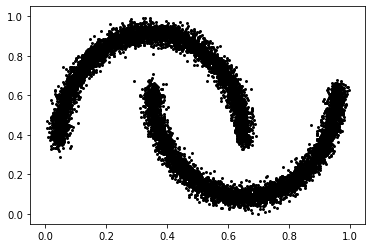

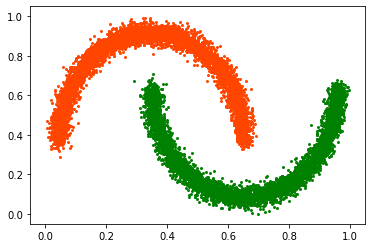

In [3]:
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
# for two moons dataset

# define normalization function
def normalize_moons(in_data):
    max_val = np.max(in_data, keepdims=True, axis=0)
    min_val = np.min(in_data, keepdims=True, axis=0)

    new_data = (in_data-min_val)/(max_val-min_val)
    mask = np.prod(((new_data < 1) & (new_data > 0 )), axis=1, dtype=bool)
    new_data = new_data[mask]
    return new_data, mask

n = 15000
n_train = 10000
X_moons, label_moon = datasets.make_moons(n_samples=n, noise=.05)
X_moons, mask = normalize_moons(X_moons)
label_moon = label_moon[mask]

X_moons, X_moons_test = X_moons[:n_train], X_moons[n_train:]
label_moon, label_moon_test = label_moon[:n_train], label_moon[n_train:]

plt.scatter(X_moons[:, 0], X_moons[:, 1], color='black', marker='.', linewidth=0)
plt.savefig("./original_two_moons.pdf")
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.show()
plt.close()

plt.scatter(X_moons[:, 0][label_moon==0], X_moons[:, 1][label_moon==0], color='orangered', marker='.', linewidth=0)
plt.scatter(X_moons[:, 0][label_moon==1], X_moons[:, 1][label_moon==1], color='green', marker='.', linewidth=0)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.savefig("./original_two_moons_cond.pdf")
plt.show()
plt.close()

## Flow training

### Regular Flow

In [4]:
n_features = 2
n_layers = 8

# Fist we define the latent space distribution, in this case a choosing a 2-dim Gaussian
base_dist = StandardNormal(shape=[n_features])

# Now we define the series of transformation that our flow model will comprise.
# For now we will use a singel MAF layer, we preemtivly implement this as a list,
# so to make it simple to extend.

# For the MAF layer we need to secify the number of input parameters, as well as the
# number of features used in the internal FCN layers.
transforms = []
for _ in range(n_layers):
    transforms.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(features=n_features, 
                                                                              hidden_features=64, 
                                                                              tail_bound = 3.0, 
                                                                              tails = "linear",
                                                                              use_residual_blocks=False))
    transforms.append(ReversePermutation(n_features))

# Finally we can combine the list of previously defined transformations into one
# single compisite transformation.
transform = CompositeTransform(transforms)

# The actual flow now consist of the the base distribution and transform together
regular_flow = Flow(transform, base_dist).to(device)

# we can then use standard PyTorch optimizers
optimizer = optim.Adam(regular_flow.parameters(), lr=5e-4)

print(regular_flow)
total_parameters = sum(p.numel() for p in regular_flow.parameters() if p.requires_grad)

print("Regular Flow has {} parameters".format(int(total_parameters)))

Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=2, out_features=64, bias=True)
          (blocks): ModuleList(
            (0): MaskedFeedforwardBlock(
              (linear): MaskedLinear(in_features=64, out_features=64, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (1): MaskedFeedforwardBlock(
              (linear): MaskedLinear(in_features=64, out_features=64, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=64, out_features=58, bias=True)
        )
      )
      (1): ReversePermutation()
      (2): MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=2, out_features=64, bias=T

In [5]:
batch_size = 200

max_batches = int(X_moons.shape[0] / batch_size)

best_NLL = np.inf

for epoch in range(num_epochs:=40):
    permut = np.random.permutation(X_moons.shape[0])
    X_moons_shuffle = X_moons[permut]

    for i_batch in range(max_batches):

        #select the current batch from the dataset
        x = X_moons_shuffle[i_batch*batch_size:(i_batch+1)*batch_size]
        x = torch.tensor(x, device=device).float()
        optimizer.zero_grad()

        #calculate negative log likelihood
        nll = -regular_flow.log_prob(x)

        #update the model
        loss = nll.mean()
        loss.backward()
        optimizer.step()
        if i_batch % 10 == 0:
            print(f"Loss: {loss}")
    x_test = torch.tensor(X_moons_test, device=device).float()
    loss_test = -regular_flow.log_prob(x_test).mean().item()
    print(f"Test loss: {loss_test}")
    if loss_test < best_NLL:
        best_NLL = loss_test
        save_weights(regular_flow, 'regular_flow')
    print(f"Done with epoch {epoch+1} / {num_epochs}.")
load_weights(regular_flow, 'regular_flow')

Loss: 2.5391690731048584
Loss: 1.264768362045288
Loss: 0.8545548915863037
Loss: 0.5927026867866516
Loss: 0.3578372597694397
Test loss: 0.08033159375190735
Model saved
Done with epoch 1 / 40.
Loss: 0.08117196708917618
Loss: -0.02790633589029312
Loss: -0.24331526458263397
Loss: -0.3213464319705963
Loss: -0.2627989649772644
Test loss: -0.44209024310112
Model saved
Done with epoch 2 / 40.
Loss: -0.4570966958999634
Loss: -0.4968968331813812
Loss: -0.5536574125289917
Loss: -0.4402214586734772
Loss: -0.6456562876701355
Test loss: -0.722653329372406
Model saved
Done with epoch 3 / 40.
Loss: -0.7812396883964539
Loss: -0.9006966352462769
Loss: -0.7105465531349182
Loss: -0.8140566945075989
Loss: -0.8055947422981262
Test loss: -0.7772491574287415
Model saved
Done with epoch 4 / 40.
Loss: -0.7181001305580139
Loss: -0.40472131967544556
Loss: -0.7634837031364441
Loss: -0.8909947276115417
Loss: -0.9203036427497864
Test loss: -0.8901026844978333
Model saved
Done with epoch 5 / 40.
Loss: -0.878134846687

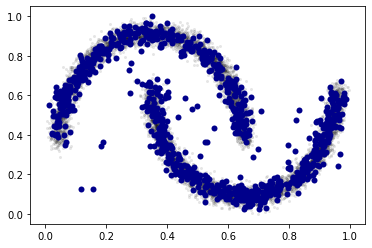

In [6]:

# Let's use the fitted distribution and sample from it
with torch.no_grad():
    samples = regular_flow.sample(1000).cpu().numpy()


#plot the results
plt.scatter(X_moons[:, 0], X_moons[:, 1], color='black', marker='.', linewidth=0, alpha=0.1)
plt.scatter(samples[:, 0], samples[:, 1], color='darkblue', marker='o', linewidth=0)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.savefig("./sampled_two_moons.pdf")
plt.show()
plt.close()

### Regular Flow - conditional

In [7]:
# Fist we define the latent space distribution, in this case a choosing a 2-dim Gaussian
n_features = 2
n_layers = 8

base_dist = StandardNormal(shape=[n_features])

# Now we define the series of transformation that our flow model will comprise.
# For now we will use a singel MAF layer, we preemtivly implement this as a list,
# so to make it simple to extend.

# For the MAF layer we need to secify the number of input parameters, as well as the
# number of features used in the internal FCN layers.
# note that now there are conditional_features!
cond_transforms = []
for _ in range(n_layers):
    cond_transforms.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(features=n_features, 
                                                                                   hidden_features=64, 
                                                                                   tail_bound = 3.0, 
                                                                                   tails = "linear", 
                                                                                   context_features=1,
                                                                                   use_residual_blocks=False))
    cond_transforms.append(ReversePermutation(n_features))

# Finally we can combine the list of previously defined transformations into one
# single compisite transformation.
cond_transform = CompositeTransform(cond_transforms)

# The actual flow now consist of the the base distribution and transform together
regular_cond_flow = Flow(cond_transform, base_dist).to(device)

# we can then use standard PyTorch optimizers
optimizer = optim.Adam(regular_cond_flow.parameters(), lr=5e-4)

print(regular_cond_flow)
total_parameters = sum(p.numel() for p in regular_cond_flow.parameters() if p.requires_grad)

print("Regular Conditional Flow has {} parameters".format(int(total_parameters)))


Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=2, out_features=64, bias=True)
          (context_layer): Linear(in_features=1, out_features=64, bias=True)
          (blocks): ModuleList(
            (0): MaskedFeedforwardBlock(
              (linear): MaskedLinear(in_features=64, out_features=64, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (1): MaskedFeedforwardBlock(
              (linear): MaskedLinear(in_features=64, out_features=64, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=64, out_features=58, bias=True)
        )
      )
      (1): ReversePermutation()
      (2): MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        (autoregressive_net): MADE(
 

In [8]:
batch_size = 200

max_batches = int(X_moons.shape[0] / batch_size)

best_NLL = np.inf

for epoch in range(num_epochs:=40):
    permut = np.random.permutation(X_moons.shape[0])
    X_moons_shuffle = X_moons[permut]
    label_moon_shuffle = label_moon[permut]

    for i_batch in range(max_batches):

        #select the current batch from the dataset
        x = X_moons_shuffle[i_batch*batch_size:(i_batch+1)*batch_size]
        x = torch.tensor(x, device=device).float()
        #y = (label_moon_shuffle[i_batch*batch_size:(i_batch+1)*batch_size] * 2) -1
        y = label_moon_shuffle[i_batch*batch_size:(i_batch+1)*batch_size]
        y = torch.tensor(y, device=device).float().view(-1, 1)

        optimizer.zero_grad()

        #calculate negative log likelihood
        nll = -regular_cond_flow.log_prob(x, context=y)

        #update the model
        loss = nll.mean()
        loss.backward()
        optimizer.step()
        if i_batch % 10 == 0:
            print(f"Loss: {loss}")
    x_test = torch.tensor(X_moons_test, device=device).float()
    y_test = torch.tensor(label_moon_test, device=device).float().view(-1, 1)
    loss_test = -regular_cond_flow.log_prob(x_test, context=y_test).mean().item()
    print(f"Test loss: {loss_test}")
    if loss_test < best_NLL:
        best_NLL = loss_test
        save_weights(regular_cond_flow, 'regular_cond_flow')
    print(f"Done with epoch {epoch+1} / {num_epochs}.")
load_weights(regular_cond_flow, 'regular_cond_flow')

Loss: 3.156240224838257
Loss: 1.2316102981567383
Loss: 0.41648542881011963
Loss: -0.122362419962883
Loss: -0.4236220419406891
Test loss: -0.5167229175567627
Model saved
Done with epoch 1 / 40.
Loss: -0.420626699924469
Loss: -0.7846291065216064
Loss: -0.9630381464958191
Loss: -0.9162846803665161
Loss: -1.0217688083648682
Test loss: -0.8910247087478638
Model saved
Done with epoch 2 / 40.
Loss: -0.8987579345703125
Loss: -1.0698353052139282
Loss: -1.315735101699829
Loss: -1.4183155298233032
Loss: -1.3742648363113403
Test loss: -1.4024631977081299
Model saved
Done with epoch 3 / 40.
Loss: -1.484250783920288
Loss: -1.3349181413650513
Loss: -1.57766592502594
Loss: -1.5492881536483765
Loss: -1.6404590606689453
Test loss: -1.5400996208190918
Model saved
Done with epoch 4 / 40.
Loss: -1.6328502893447876
Loss: -1.6111880540847778
Loss: -1.5613534450531006
Loss: -1.6813912391662598
Loss: -1.636330485343933
Test loss: -1.7956959009170532
Model saved
Done with epoch 5 / 40.
Loss: -1.8150920867919922

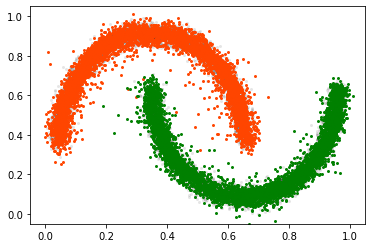

In [9]:
n_samples = 5000

cond1 = np.ones((n_samples,1))
cond0 = np.zeros((n_samples,1))
#cond0 = -1.* np.ones((n_samples,1))

cond1 = torch.tensor(cond1).float().to(device)
with torch.no_grad():
    samples1 = regular_cond_flow.sample(1, context=cond1).view(n_samples, -1).cpu().numpy()

cond0 = torch.tensor(cond0).float().to(device)
with torch.no_grad():
    samples0 = regular_cond_flow.sample(1, context=cond0).view(n_samples, -1).cpu().numpy()

plt.scatter(X_moons[:, 0], X_moons[:, 1], color='black', marker='.', linewidth=0, alpha=0.1)
plt.scatter(samples0[:, 0], samples0[:, 1], color='orangered', marker='.', linewidth=0)
plt.scatter(samples1[:, 0], samples1[:, 1], color='green', marker='.', linewidth=0)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.savefig("./sampled_two_moons_cond.pdf")
plt.show()
plt.close()


### Bit Flow

In [10]:
n_features = 2
n_layers = 8

# Fist we define the latent space distribution, in this case a choosing a 2-dim Gaussian
base_dist = StandardNormal(shape=[n_features])

# Now we define the series of transformation that our flow model will comprise.
# For now we will use a singel MAF layer, we preemtivly implement this as a list,
# so to make it simple to extend.

# For the MAF layer we need to secify the number of input parameters, as well as the
# number of features used in the internal FCN layers.
bit_transforms = []
for _ in range(n_layers):
    bit_transforms.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(features=n_features, 
                                                                                  hidden_features=64, 
                                                                                  tail_bound = 3.0, 
                                                                                  tails = "linear",
                                                                                  use_residual_blocks=False,
                                                                                  useBitNet=True,
                                                                                  use_ternary=False))
    bit_transforms.append(ReversePermutation(n_features))

# Finally we can combine the list of previously defined transformations into one
# single compisite transformation.
bit_transform = CompositeTransform(bit_transforms)

# The actual flow now consist of the the base distribution and transform together
bit_flow = Flow(bit_transform, base_dist).to(device)

# we can then use standard PyTorch optimizers
optimizer = optim.Adam(bit_flow.parameters(), lr=1e-3)

print(bit_flow)
total_parameters = sum(p.numel() for p in bit_flow.parameters() if p.requires_grad)

print("Bit Flow has {} parameters".format(int(total_parameters)))

Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        (autoregressive_net): MADE_BitNet(
          (initial_layer): MaskedBitLinear(in_features=2, out_features=64, bias=True)
          (blocks): ModuleList(
            (0): MaskedBitLinear(in_features=64, out_features=64, bias=True)
            (1): MaskedBitLinear(in_features=64, out_features=64, bias=True)
          )
          (final_layer): MaskedBitLinear(in_features=64, out_features=58, bias=True)
        )
      )
      (1): ReversePermutation()
      (2): MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        (autoregressive_net): MADE_BitNet(
          (initial_layer): MaskedBitLinear(in_features=2, out_features=64, bias=True)
          (blocks): ModuleList(
            (0): MaskedBitLinear(in_features=64, out_features=64, bias=True)
            (1): MaskedBitLinear(in_features=64, out_features=64, bias=True)
          )
  

In [11]:
batch_size = 200

max_batches = int(X_moons.shape[0] / batch_size)

best_NLL = np.inf

for epoch in range(num_epochs:=40):
    permut = np.random.permutation(X_moons.shape[0])
    X_moons_shuffle = X_moons[permut]

    for i_batch in range(max_batches):

        #select the current batch from the dataset
        x = X_moons_shuffle[i_batch*batch_size:(i_batch+1)*batch_size]
        x = torch.tensor(x, device=device).float()
        optimizer.zero_grad()

        #calculate negative log likelihood
        nll = -bit_flow.log_prob(x)

        #update the model
        loss = nll.mean()
        loss.backward()
        optimizer.step()
        if i_batch % 10 == 0:
            print(f"Loss: {loss}")
    x_test = torch.tensor(X_moons_test, device=device).float()
    loss_test = -bit_flow.log_prob(x_test).mean().item()
    print(f"Test loss: {loss_test}")
    if loss_test < best_NLL:
        best_NLL = loss_test
        save_weights(bit_flow, 'bit_flow')
    print(f"Done with epoch {epoch+1} / {num_epochs}.")
load_weights(bit_flow, 'bit_flow')

Loss: 3.680103063583374
Loss: 2.693927526473999
Loss: 2.381404161453247
Loss: 1.6148889064788818
Loss: 1.4865436553955078
Test loss: 1.1098977327346802
Model saved
Done with epoch 1 / 40.
Loss: 1.1991075277328491
Loss: 0.9555296301841736
Loss: 0.6524261832237244
Loss: 0.7583518624305725
Loss: 0.3625653088092804
Test loss: 0.3551149070262909
Model saved
Done with epoch 2 / 40.
Loss: 0.37554100155830383
Loss: 0.2965507507324219
Loss: 0.437717080116272
Loss: 0.16614151000976562
Loss: 0.10905852913856506
Test loss: 0.11204531043767929
Model saved
Done with epoch 3 / 40.
Loss: 0.10834264755249023
Loss: 0.00960061326622963
Loss: -0.1268489509820938
Loss: -0.280306875705719
Loss: -0.452502965927124
Test loss: -0.290420264005661
Model saved
Done with epoch 4 / 40.
Loss: -0.3294451832771301
Loss: -0.40019094944000244
Loss: -0.5104613900184631
Loss: -0.44099050760269165
Loss: -0.4395734965801239
Test loss: -0.37606021761894226
Model saved
Done with epoch 5 / 40.
Loss: -0.3595966696739197
Loss: -

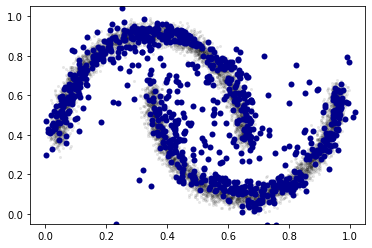

In [12]:

# Let's use the fitted distribution and sample from it
with torch.no_grad():
    samples = bit_flow.sample(1000).cpu().numpy()


#plot the results
plt.scatter(X_moons[:, 0], X_moons[:, 1], color='black', marker='.', linewidth=0, alpha=0.1)
plt.scatter(samples[:, 0], samples[:, 1], color='darkblue', marker='o', linewidth=0)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.savefig("./sampled_two_moons_bit.pdf")
plt.show()
plt.close()

### Bit Flow - conditional

In [13]:
# Fist we define the latent space distribution, in this case a choosing a 2-dim Gaussian
n_features = 2
n_layers = 8

base_dist = StandardNormal(shape=[n_features])

# Now we define the series of transformation that our flow model will comprise.
# For now we will use a singel MAF layer, we preemtivly implement this as a list,
# so to make it simple to extend.

# For the MAF layer we need to secify the number of input parameters, as well as the
# number of features used in the internal FCN layers.
# note that now there are conditional_features!
bit_cond_transforms = []
for _ in range(n_layers):
    bit_cond_transforms.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(features=n_features, 
                                                                                   hidden_features=64, 
                                                                                   tail_bound = 3.0, 
                                                                                   tails = "linear", 
                                                                                   context_features=1,
                                                                                   use_residual_blocks=False,
                                                                                   useBitNet=True,
                                                                                   use_ternary=False
                                                                                      ))
    bit_cond_transforms.append(ReversePermutation(n_features))

# Finally we can combine the list of previously defined transformations into one
# single compisite transformation.
bit_cond_transform = CompositeTransform(bit_cond_transforms)

# The actual flow now consist of the the base distribution and transform together
bit_cond_flow = Flow(bit_cond_transform, base_dist).to(device)

# we can then use standard PyTorch optimizers
optimizer = optim.Adam(bit_cond_flow.parameters(), lr=1e-3)

print(bit_cond_flow)
total_parameters = sum(p.numel() for p in bit_cond_flow.parameters() if p.requires_grad)

print("BitNet Conditional Flow has {} parameters".format(int(total_parameters)))


Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        (autoregressive_net): MADE_BitNet(
          (initial_layer): MaskedBitLinear(in_features=2, out_features=64, bias=True)
          (context_layer): BitLinear(in_features=1, out_features=64, bias=True)
          (blocks): ModuleList(
            (0): MaskedBitLinear(in_features=64, out_features=64, bias=True)
            (1): MaskedBitLinear(in_features=64, out_features=64, bias=True)
          )
          (final_layer): MaskedBitLinear(in_features=64, out_features=58, bias=True)
        )
      )
      (1): ReversePermutation()
      (2): MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        (autoregressive_net): MADE_BitNet(
          (initial_layer): MaskedBitLinear(in_features=2, out_features=64, bias=True)
          (context_layer): BitLinear(in_features=1, out_features=64, bias=True)
          (blocks): ModuleList(
        

In [14]:
batch_size = 200

max_batches = int(X_moons.shape[0] / batch_size)

best_NLL = np.inf

for epoch in range(num_epochs:=40):
    permut = np.random.permutation(X_moons.shape[0])
    X_moons_shuffle = X_moons[permut]
    label_moon_shuffle = label_moon[permut]

    for i_batch in range(max_batches):

        #select the current batch from the dataset
        x = X_moons_shuffle[i_batch*batch_size:(i_batch+1)*batch_size]
        x = torch.tensor(x, device=device).float()
        #y = (label_moon_shuffle[i_batch*batch_size:(i_batch+1)*batch_size] * 2) - 1
        y = label_moon_shuffle[i_batch*batch_size:(i_batch+1)*batch_size]
        y = torch.tensor(y, device=device).float().view(-1, 1)

        optimizer.zero_grad()

        #calculate negative log likelihood
        nll = -bit_cond_flow.log_prob(x, context=y)

        #update the model
        loss = nll.mean()
        loss.backward()
        optimizer.step()
        if i_batch % 10 == 0:
            print(f"Loss: {loss}")
    x_test = torch.tensor(X_moons_test, device=device).float()
    y_test = torch.tensor(label_moon_test, device=device).float().view(-1, 1)
    loss_test = -bit_cond_flow.log_prob(x_test, context=y_test).mean().item()
    print(f"Test loss: {loss_test}")
    if loss_test < best_NLL:
        best_NLL = loss_test
        save_weights(bit_cond_flow, 'bit_cond_flow')
    print(f"Done with epoch {epoch+1} / {num_epochs}.")
load_weights(bit_cond_flow, 'bit_cond_flow')

Loss: 3.4002327919006348
Loss: 1.9454723596572876
Loss: 1.1809349060058594
Loss: 0.7196449637413025
Loss: 0.275885671377182
Test loss: 0.1722676157951355
Model saved
Done with epoch 1 / 40.
Loss: 0.1612323671579361
Loss: -0.12025105953216553
Loss: -0.17927418649196625
Loss: -0.35382428765296936
Loss: -0.7107699513435364
Test loss: -0.652717649936676
Model saved
Done with epoch 2 / 40.
Loss: -0.6842419505119324
Loss: -0.49269354343414307
Loss: -0.09010551869869232
Loss: -0.6007806062698364
Loss: -0.47894445061683655
Test loss: -0.742948055267334
Model saved
Done with epoch 3 / 40.
Loss: -0.6398731470108032
Loss: -0.8116020560264587
Loss: -0.7680273056030273
Loss: -0.8812952041625977
Loss: -0.9253153800964355
Test loss: -0.792230486869812
Model saved
Done with epoch 4 / 40.
Loss: -0.8107395172119141
Loss: -0.5676482319831848
Loss: -0.6993809938430786
Loss: -0.9998603463172913
Loss: -1.0702012777328491
Test loss: -1.0338119268417358
Model saved
Done with epoch 5 / 40.
Loss: -1.10758662223

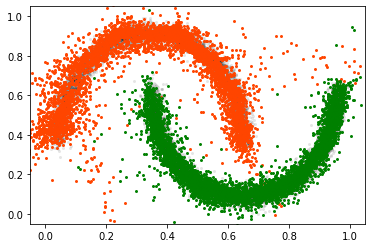

In [15]:
n_samples = 5000

cond1 = np.ones((n_samples,1))
cond0 = np.zeros((n_samples,1))
#cond0 = -1* np.ones((n_samples,1))

cond1 = torch.tensor(cond1).float().to(device)
with torch.no_grad():
    samples1 = bit_cond_flow.sample(1, context=cond1).view(n_samples, -1).cpu().numpy()

cond0 = torch.tensor(cond0).float().to(device)
with torch.no_grad():
    samples0 = bit_cond_flow.sample(1, context=cond0).view(n_samples, -1).cpu().numpy()

plt.scatter(X_moons[:, 0], X_moons[:, 1], color='black', marker='.', linewidth=0, alpha=0.1)
plt.scatter(samples0[:, 0], samples0[:, 1], color='orangered', marker='.', linewidth=0)
plt.scatter(samples1[:, 0], samples1[:, 1], color='green', marker='.', linewidth=0)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.savefig("./sampled_two_moons_cond_bit.pdf")
plt.show()
plt.close()


### 1.58b BitFlow

In [16]:
n_features = 2
n_layers = 8

# Fist we define the latent space distribution, in this case a choosing a 2-dim Gaussian
base_dist = StandardNormal(shape=[n_features])

# Now we define the series of transformation that our flow model will comprise.
# For now we will use a singel MAF layer, we preemtivly implement this as a list,
# so to make it simple to extend.

# For the MAF layer we need to secify the number of input parameters, as well as the
# number of features used in the internal FCN layers.
bit158_transforms = []
for _ in range(n_layers):
    bit158_transforms.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(features=n_features, 
                                                                                  hidden_features=64, 
                                                                                  tail_bound = 3.0, 
                                                                                  tails = "linear",
                                                                                  use_residual_blocks=False,
                                                                                  useBitNet=True,
                                                                                  use_ternary=True))
    bit158_transforms.append(ReversePermutation(n_features))

# Finally we can combine the list of previously defined transformations into one
# single compisite transformation.
bit158_transform = CompositeTransform(bit158_transforms)

# The actual flow now consist of the the base distribution and transform together
bit158_flow = Flow(bit158_transform, base_dist).to(device)

# we can then use standard PyTorch optimizers
optimizer = optim.Adam(bit158_flow.parameters(), lr=1e-3)

print(bit158_flow)
total_parameters = sum(p.numel() for p in bit158_flow.parameters() if p.requires_grad)

print("1.58b Bit Flow has {} parameters".format(int(total_parameters)))

Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        (autoregressive_net): MADE_BitNet(
          (initial_layer): MaskedBitLinear158b(in_features=2, out_features=64, bias=True)
          (blocks): ModuleList(
            (0): MaskedBitLinear158b(in_features=64, out_features=64, bias=True)
            (1): MaskedBitLinear158b(in_features=64, out_features=64, bias=True)
          )
          (final_layer): MaskedBitLinear158b(in_features=64, out_features=58, bias=True)
        )
      )
      (1): ReversePermutation()
      (2): MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        (autoregressive_net): MADE_BitNet(
          (initial_layer): MaskedBitLinear158b(in_features=2, out_features=64, bias=True)
          (blocks): ModuleList(
            (0): MaskedBitLinear158b(in_features=64, out_features=64, bias=True)
            (1): MaskedBitLinear158b(in_features=64, out_features=6

In [17]:
batch_size = 200

max_batches = int(X_moons.shape[0] / batch_size)

best_NLL = np.inf

for epoch in range(num_epochs:=40):
    permut = np.random.permutation(X_moons.shape[0])
    X_moons_shuffle = X_moons[permut]

    for i_batch in range(max_batches):

        #select the current batch from the dataset
        x = X_moons_shuffle[i_batch*batch_size:(i_batch+1)*batch_size]
        x = torch.tensor(x, device=device).float()
        optimizer.zero_grad()

        #calculate negative log likelihood
        nll = -bit158_flow.log_prob(x)

        #update the model
        loss = nll.mean()
        loss.backward()
        optimizer.step()
        if i_batch % 10 == 0:
            print(f"Loss: {loss}")
    x_test = torch.tensor(X_moons_test, device=device).float()
    loss_test = -bit158_flow.log_prob(x_test).mean().item()
    print(f"Test loss: {loss_test}")
    if loss_test < best_NLL:
        best_NLL = loss_test
        save_weights(bit158_flow, 'bit158_flow')
    print(f"Done with epoch {epoch+1} / {num_epochs}.")
load_weights(bit158_flow, 'bit158_flow')

Loss: 3.58059024810791
Loss: 2.6403777599334717
Loss: 1.999533772468567
Loss: 1.4620848894119263
Loss: 1.1909289360046387
Test loss: 0.9463486671447754
Model saved
Done with epoch 1 / 40.
Loss: 0.9486891031265259
Loss: 0.8212199211120605
Loss: 0.3588698208332062
Loss: 0.16808128356933594
Loss: 0.16680890321731567
Test loss: -0.10321450233459473
Model saved
Done with epoch 2 / 40.
Loss: -0.1881631761789322
Loss: -0.06242655590176582
Loss: 0.08243453502655029
Loss: 0.009828322567045689
Loss: -0.16693629324436188
Test loss: -0.33928653597831726
Model saved
Done with epoch 3 / 40.
Loss: -0.3329218924045563
Loss: 0.06016300618648529
Loss: -0.004277169704437256
Loss: -0.12824594974517822
Loss: -0.18051449954509735
Test loss: -0.33630022406578064
Done with epoch 4 / 40.
Loss: -0.31755194067955017
Loss: -0.3590409755706787
Loss: -0.334425687789917
Loss: 0.039453279227018356
Loss: -0.30331411957740784
Test loss: -0.5148769021034241
Model saved
Done with epoch 5 / 40.
Loss: -0.3922674059867859
L

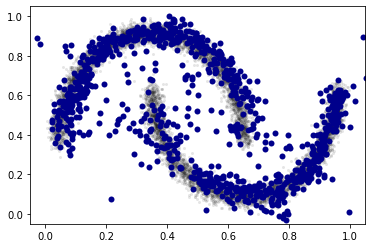

In [18]:

# Let's use the fitted distribution and sample from it
with torch.no_grad():
    samples = bit158_flow.sample(1000).cpu().numpy()


#plot the results
plt.scatter(X_moons[:, 0], X_moons[:, 1], color='black', marker='.', linewidth=0, alpha=0.1)
plt.scatter(samples[:, 0], samples[:, 1], color='darkblue', marker='o', linewidth=0)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.savefig("./sampled_two_moons_158bit.pdf")
plt.show()
plt.close()

### 1.58 BitFlow - conditional

In [19]:
# Fist we define the latent space distribution, in this case a choosing a 2-dim Gaussian
n_features = 2
n_layers = 8

base_dist = StandardNormal(shape=[n_features])

# Now we define the series of transformation that our flow model will comprise.
# For now we will use a singel MAF layer, we preemtivly implement this as a list,
# so to make it simple to extend.

# For the MAF layer we need to secify the number of input parameters, as well as the
# number of features used in the internal FCN layers.
# note that now there are conditional_features!
bit158_cond_transforms = []
for _ in range(n_layers):
    bit158_cond_transforms.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(features=n_features, 
                                                                                   hidden_features=64, 
                                                                                   tail_bound = 3.0, 
                                                                                   tails = "linear", 
                                                                                   context_features=1,
                                                                                   use_residual_blocks=False,
                                                                                   useBitNet=True,
                                                                                   use_ternary=True
                                                                                      ))
    bit158_cond_transforms.append(ReversePermutation(n_features))

# Finally we can combine the list of previously defined transformations into one
# single compisite transformation.
bit158_cond_transform = CompositeTransform(bit158_cond_transforms)

# The actual flow now consist of the the base distribution and transform together
bit158_cond_flow = Flow(bit158_cond_transform, base_dist).to(device)

# we can then use standard PyTorch optimizers
optimizer = optim.Adam(bit158_cond_flow.parameters(), lr=1e-3)

print(bit158_cond_flow)
total_parameters = sum(p.numel() for p in bit158_cond_flow.parameters() if p.requires_grad)

print("1.58 BitNet Conditional Flow has {} parameters".format(int(total_parameters)))


Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        (autoregressive_net): MADE_BitNet(
          (initial_layer): MaskedBitLinear158b(in_features=2, out_features=64, bias=True)
          (context_layer): BitLinear158b(in_features=1, out_features=64, bias=True)
          (blocks): ModuleList(
            (0): MaskedBitLinear158b(in_features=64, out_features=64, bias=True)
            (1): MaskedBitLinear158b(in_features=64, out_features=64, bias=True)
          )
          (final_layer): MaskedBitLinear158b(in_features=64, out_features=58, bias=True)
        )
      )
      (1): ReversePermutation()
      (2): MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        (autoregressive_net): MADE_BitNet(
          (initial_layer): MaskedBitLinear158b(in_features=2, out_features=64, bias=True)
          (context_layer): BitLinear158b(in_features=1, out_features=64, bias=True)
          (b

In [20]:
batch_size = 200

max_batches = int(X_moons.shape[0] / batch_size)

best_NLL = np.inf

for epoch in range(num_epochs:=40):
    permut = np.random.permutation(X_moons.shape[0])
    X_moons_shuffle = X_moons[permut]
    label_moon_shuffle = label_moon[permut]

    for i_batch in range(max_batches):

        #select the current batch from the dataset
        x = X_moons_shuffle[i_batch*batch_size:(i_batch+1)*batch_size]
        x = torch.tensor(x, device=device).float()
        #y = (label_moon_shuffle[i_batch*batch_size:(i_batch+1)*batch_size] * 2) -1
        y = label_moon_shuffle[i_batch*batch_size:(i_batch+1)*batch_size]
        y = torch.tensor(y, device=device).float().view(-1, 1)

        optimizer.zero_grad()

        #calculate negative log likelihood
        nll = -bit158_cond_flow.log_prob(x, context=y)

        #update the model
        loss = nll.mean()
        loss.backward()
        optimizer.step()
        if i_batch % 10 == 0:
            print(f"Loss: {loss}")
    x_test = torch.tensor(X_moons_test, device=device).float()
    y_test = torch.tensor(label_moon_test, device=device).float().view(-1, 1)
    loss_test = -bit158_cond_flow.log_prob(x_test, context=y_test).mean().item()
    print(f"Test loss: {loss_test}")
    if loss_test < best_NLL:
        best_NLL = loss_test
        save_weights(bit158_cond_flow, 'bit158_cond_flow')
    print(f"Done with epoch {epoch+1} / {num_epochs}.")
load_weights(bit158_cond_flow, 'bit158_cond_flow')

Loss: 3.3418900966644287
Loss: 1.7906064987182617
Loss: 0.7833146452903748
Loss: 0.2981269657611847
Loss: 0.03915873542428017
Test loss: -0.24005566537380219
Model saved
Done with epoch 1 / 40.
Loss: -0.24681250751018524
Loss: -0.41416898369789124
Loss: -0.3123832941055298
Loss: -0.7582172751426697
Loss: -0.9522171020507812
Test loss: -0.9236775040626526
Model saved
Done with epoch 2 / 40.
Loss: -0.8328427076339722
Loss: -1.0694540739059448
Loss: -0.7524592280387878
Loss: -1.230849027633667
Loss: -0.9736996293067932
Test loss: -1.2328083515167236
Model saved
Done with epoch 3 / 40.
Loss: -1.203877568244934
Loss: -0.9613634943962097
Loss: -1.2687149047851562
Loss: -1.3819175958633423
Loss: -1.0030889511108398
Test loss: -1.1170576810836792
Done with epoch 4 / 40.
Loss: -1.0763405561447144
Loss: -1.2306171655654907
Loss: -1.2840594053268433
Loss: -1.414002537727356
Loss: -1.2794837951660156
Test loss: -1.4279173612594604
Model saved
Done with epoch 5 / 40.
Loss: -1.4672685861587524
Loss:

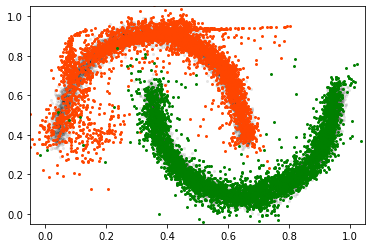

In [21]:
n_samples = 5000

cond1 = np.ones((n_samples,1))
cond0 = np.zeros((n_samples,1))
#cond0 = -1 * np.ones((n_samples,1))

cond1 = torch.tensor(cond1).float().to(device)
with torch.no_grad():
    samples1 = bit158_cond_flow.sample(1, context=cond1).view(n_samples, -1).cpu().numpy()

cond0 = torch.tensor(cond0).float().to(device)
with torch.no_grad():
    samples0 = bit158_cond_flow.sample(1, context=cond0).view(n_samples, -1).cpu().numpy()

plt.scatter(X_moons[:, 0], X_moons[:, 1], color='black', marker='.', linewidth=0, alpha=0.1)
plt.scatter(samples0[:, 0], samples0[:, 1], color='orangered', marker='.', linewidth=0)
plt.scatter(samples1[:, 0], samples1[:, 1], color='green', marker='.', linewidth=0)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.savefig("./sampled_two_moons_cond_158bit.pdf")
plt.show()
plt.close()
